In [1]:
include("JDE_ODE.jl")
import .JDE_ODE: RK2, Heun, RK4
import ..JDE_ODE: ODEProblem, ODESolution, solve #These functions are in the Base module, so you have to use .. to get to them.
using Test, Plots

In [2]:
function test_RK2()
    @testset "RK2 Tests" begin
        
        @testset "Scalar Test - Linear Decay" begin
            # Test problem y' = -y, y(0) = 1
            # Exact solution: y(t) = exp(-t)
            f(y,t) = -y
            y₀ = 1.0
            T = 1.0
            h = 0.1
            problem = ODEProblem(f, y₀, T, h)
            solution = solve(problem, RK2())
            exact = exp.(-solution.t)
            @test solution.y ≈ exact atol=1e-2
        end
        
        @testset "Vector Test - Coupled System" begin
            # Test problem y' = Ay where A = [-1 1; 1 -1]
            # Simple oscillatory system
            A = [-1.0 1.0; 1.0 -1.0]
            f(y,t) = A*y
            y₀ = [1.0, 0.0]
            T = 1.0
            h = 0.1
            problem = ODEProblem(f, y₀, T, h)
            solution = solve(problem, RK2())
            # Compare with reference solution (could be RK4 with small timestep)
            ref_h = 0.001
            ref_prob = ODEProblem(f, y₀, T, ref_h)
            reference = solve(ref_prob, RK4())
            # Interpolate reference solution to match solution times
            ref_indices = Int.(round.(solution.t/ref_h)) .+ 1
            @test solution.y ≈ reference.y[ref_indices] atol=1e-2
        end
    end
end

test_RK2()

Test Summary: | Pass  Total  Time
RK2 Tests     |    2      2  0.5s


Test.DefaultTestSet("RK2 Tests", Any[Test.DefaultTestSet("Scalar Test - Linear Decay", Any[], 1, false, false, true, 1.738609363895797e9, 1.738609364014541e9, false, "/Users/joeleaves/github/CHEM-5555/Numerical Solutions to Differential Equations/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W3sZmlsZQ==.jl"), Test.DefaultTestSet("Vector Test - Coupled System", Any[], 1, false, false, true, 1.73860936401456e9, 1.73860936440865e9, false, "/Users/joeleaves/github/CHEM-5555/Numerical Solutions to Differential Equations/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W3sZmlsZQ==.jl")], 0, false, false, true, 1.738609363895775e9, 1.738609364408651e9, false, "/Users/joeleaves/github/CHEM-5555/Numerical Solutions to Differential Equations/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W3sZmlsZQ==.jl")

**The van der Pol Oscillator**

Let's use our differential equation integrators to study the van der Pol oscillator.  This is a differential equation that satisfies

\begin{equation}
\frac{d^2x}{dt^2} - \mu(1-x^2)\frac{dx}{dt} + x = 0.
\end{equation}

Let's store our vector as

\begin{equation}
\Gamma = \begin{pmatrix} x \\ v \end{pmatrix}
\end{equation}

where $v = \frac{dx}{dt}$ is the velocity.

Then we have a system of coupled differential equations, using the dot notation for time derivatives, $\dot{x} \equiv \frac{dx}{dt}$, for example,

$$
\begin{align}
\dot{x} &= v \\
\dot{v} &= \mu(1 - x^2) v - x \\
\end{align}
$$

In [3]:
function vdp_derivative(Γ::Vector{Float64},μ::Float64)
    x = Γ[1]
    v = Γ[2]
    return [v, -x + μ*(1 - x^2)*v]
end

function van_der_pol(; μ=1.0, Γ₀=[1.0, 0.0], T=10.0, h=0.1)
    return ODEProblem((Γ,t) -> vdp_derivative(Γ,μ), Γ₀, T, h)
end

function test_van_der_pol()
    @testset "Van der Pol Tests" begin
        @testset "μ = 0" begin
            μ_ = 0.0
            Γ₀_ = [1.0, 0.0]
            problem = van_der_pol(μ=μ_)
            solution = solve(problem, RK2())
            # Compare with reference solution (could be RK4 with small timestep)
            ref_h = 0.001
            ref_prob = van_der_pol(μ=μ_, h = ref_h)
            reference = solve(ref_prob, RK4())
            # Interpolate reference solution to match solution times
            ref_indices = Int.(round.(solution.t/ref_h)) .+ 1
            @test solution.y ≈ reference.y[ref_indices] atol=1e-1
        end
    end
end

test_van_der_pol()


Test Summary:     | Pass  Total  Time
Van der Pol Tests |    1      1  0.0s


Test.DefaultTestSet("Van der Pol Tests", Any[Test.DefaultTestSet("μ = 0", Any[], 1, false, false, true, 1.738609379701031e9, 1.738609379712888e9, false, "/Users/joeleaves/github/CHEM-5555/Numerical Solutions to Differential Equations/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W5sZmlsZQ==.jl")], 0, false, false, true, 1.738609379701023e9, 1.738609379712889e9, false, "/Users/joeleaves/github/CHEM-5555/Numerical Solutions to Differential Equations/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W5sZmlsZQ==.jl")

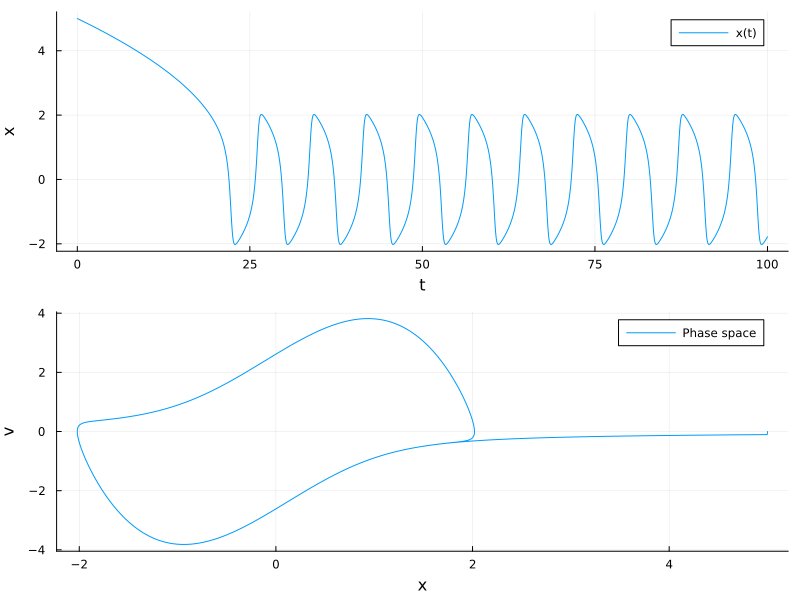

In [ ]:
# Solve van der Pol with μ = 1
print("Starting the problem in the region of decay.")
x₀ = 5.0
v₀ = 0.0

problem = van_der_pol(μ=2.0, Γ₀=[x₀, v₀], T=100.0, h=0.01)
solution = solve(problem, RK4())

# Create two subplots: one for x(t), one for phase space
p1 = plot(solution.t, getindex.(solution.y, 1), 
          label="x(t)", xlabel="t", ylabel="x")
p2 = plot(getindex.(solution.y, 1), getindex.(solution.y, 2), 
          label="Phase space", xlabel="x", ylabel="v")
plot(p1, p2, layout=(2,1), size=(800,600))

print("The solution is oscillatory---the system decays to a limit cycle.")